In [2]:
import numpy as np
import csv
from matplotlib import pyplot as plt
import scipy.stats as stats
from IPython.core.pylabtools import figsize
from nipy import load_image, save_image
from nipy.core.api import Image

In [3]:
### Generate data 

def get_data(nii_file):
    image = load_image(nii_file)
    return image.get_data()

def subject_noise(tract, tau):
    noise = stats.norm.rvs(0, tau, size=tract.shape)  
    return tract + noise

def generate_additive(gamma, tau, size):
    ## tau == standard deviation (not variance or 1/t)
    return stats.norm.rvs(gamma, tau, size=size)
     
def generate_multiplicative(lamb, theta, size):
    return stats.invgamma.rvs(lamb, scale=theta, size=size)
    
def generate_noise(tau, size):
    ## tau == standard deviation (not variance or 1/t)
    return stats.norm.rvs(0, tau, size=size)

def add_noise(tract_profile, scanner):
    additive = generate_additive(scanner["gamma"], scanner["tau"], tract_profile.shape) 
    multiplicative = generate_multiplicative(scanner["lamb"], scanner["theta"], tract_profile.shape) 
    error = generate_noise(scanner["tau"], tract_profile.shape)
#    print("Additive max: {0}".format(np.max(additive)))
#    print("Mult max: {0}".format(np.max(multiplicative))) 
#    print("Err max: {0}".format(np.max(error)))   
    return tract_profile + additive + multiplicative + error



In [4]:
#Generate data
scanner_list = ["scanner1", "scanner2"]

scanner_pars = {"scanner1" : {"gamma": 0.01,
                        "tau": 0.001,
                        "lamb": 20,
                        "theta": 2,
                        "prob": 0.45},
             "scanner2": {"gamma": 0.02,
                        "tau": 0.002,
                        "lamb": 22,
                        "theta": 2.1,
                        "prob": 0.55}}
 

subjects_csv = []
with open('./FA_along_CST_R_I-S.csv', 'rb') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        subjects_csv.append(row)
    subjects = np.asarray(subjects_csv, dtype=np.float)
 
subject1 = subjects[:, 0] 
subject2 = subjects[:, 1] 
print(subject1.shape)

subject_list = [subject1, subject2]

n_subjects = 20 #number of total samples
scanner_source = np.random.binomial(1, 0.5, n_subjects)
subject_source = np.random.binomial(1, 0.5, n_subjects)

print(scanner_source)
print(subject_source)

profiles=[]
for idx in np.arange(len(scanner_source)):
    scanner = scanner_list[scanner_source[idx]]
    sub_idx = subject_source[idx]
    scanner_par = scanner_pars[scanner]
    new_image = subject_noise(subject_list[sub_idx], 0.04)
    profile = add_noise(new_image, scanner_par)
    profiles.append(profile) 
     

(182,)
[1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1]
[1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1]


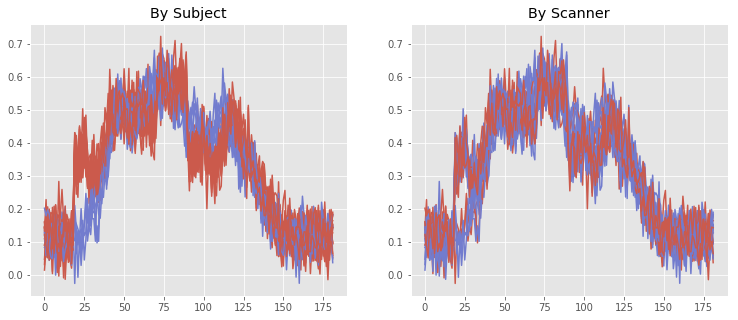

In [5]:
figsize(12.5, 5)
cols = ["#727cce", "#cb5a4c"]

plt.style.use('ggplot')
plt.subplot(121)   
BC = []
X = np.arange(0, profiles[0].shape[0])
for i in range(len(profiles)):
    plt.plot(X, profiles[i], c=cols[subject_source[i]])
    plt.title("By Subject")
 
plt.subplot(122)


BC = []
X = np.arange(0, profiles[0].shape[0])
for i in range(len(profiles)):
    plt.plot(X, profiles[i], c=cols[scanner_source[i]])
    plt.title("By Scanner")

plt.savefig("dist.png")